# Portfolio Optimization with Genetic Programming

# 1. Defining the terminals
In this first step we define the Primitive set (`pset`). The `pset` contains the functions, constants and input parameters our tree will be build of.

First define the input parameters for the generated trees.

In [1]:
from deap import base, creator, tools, gp, algorithms
import operator, math, random, csv
from stock import Stock
import pandas as pd
import numpy as np
from tree_plot import *

pset = gp.PrimitiveSetTyped("main", [list], list)

Define primitive functions for the nodes. The first parameter defines the function, the second the types of the input parameters and the third one the type of the output.

In [2]:
from stock_functions import *

# pset.addPrimitive(sell, [list], list)
pset.addPrimitive(buy, [list, str], list)
# pset.addPrimitive(get_random_sym, [int], str)
# pset.addPrimitive(get_seed, [], int)

# pset.addEphemeralConstant('seed', lambda: get_seed(), int)
pset.addEphemeralConstant('sym', lambda: get_random_sym(), str)

Renaming the input parameter

In [3]:
pset.renameArguments(ARG0="stocks")

# 2. Defining Object types
In any evolutionary program, we need some basic object types. In this case we need two, a fitness type and the type for individuals. In this problem we are facing an maximization and minimization problem (maximize the value and minimize the tree size)(so the one value is positive and the other one is negative). The individual will be based upon a tree, to which we add the defined fitness.

In [4]:
creator.create("Fitness", base.Fitness, weights=(1.0, ))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.Fitness, pset=pset)

# 3. Define helper functions
Register functions that we during the whole algorithm (generate, evaluate, mutate, ...). Any structure with access to the toolbox will also have access to all of those registered parameters.

## 3.1 Generating individuals

In [5]:
toolbox = base.Toolbox()
# Defines how a tree expression looks like
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
# How an individual should be generated (in this case as a tree)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
# How the population of individuals should look like
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

## 3.2 Evaluation of trees
Define functions that help us to evaluate an individuum. This includes to calculate the fitness. But first we need to generate executable pythoncode out of our tree individuals.

To get working python code out of our generated tree we can use the `gp.compile` function.

In [6]:
# Generates Python code out of trees
toolbox.register("compile", gp.compile, pset=pset)

def evaluate(tree):
    # using the previously defined compile function
    function = toolbox.compile(tree)
    # Executing the function with some test input


    stocks = [Stock('AAPL'), Stock('TSLA'), Stock('QQQ')]

    result = function(stocks)

    start = datetime(2015, 4, 12)
    end = datetime(2018, 11, 23)
    profit = 0.0
    for asset in result:
        profit += asset.get_avg_profit(start, end)
    
    if len(result) > 0:
        profit = profit / len(result)
        return profit if not pd.isna(profit) else 0, 
    else:
        return 0.0,

# Now add the evaluation Function to our toolbox
toolbox.register("evaluate", evaluate)

## 3.3 Selection for next generation
We choose the selection method (a tournament of size 3).

In [7]:
toolbox.register("select", tools.selTournament, tournsize=3)

## 3.4 Mutation
Define random mutations for individuals. 

In [8]:
# Defines how the expression of a tree mutation should look like
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
# How the mutation should be applied
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
# Limit the height of individual to avoid bloat
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))

# Crossover
toolbox.register("mate", gp.cxOnePointLeafBiased, termpb=0.2)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))

# 4. Add some statistics
 In this case, we want to compute the mean, standard deviation, minimum, and maximum of both the individuals fitness and size.

In [9]:
def stats():
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)
    return mstats

# 5. Plott trees

In [10]:
def plot(trees):
    write_file(trees[0])
    for index, tree in zip(range(len(trees)), trees):
        # Generate Graph
        print("generate Graph for tree " + str(index))
        nodes, edges, labels = gp.graph(tree)
        plot_tree(nodes, edges, labels, 'tree' + str(index))

# 6. Launch

   	      	                         fitness                         	                      size                     
   	      	---------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max     	min	nevals	std      	avg	gen	max	min	nevals	std    
0  	30    	0.11339	0  	0.340167	0  	30    	0.0870604	5.2	0  	9  	3  	30    	2.16641
1  	22    	0.16361	1  	0.335215	0  	22    	0.0730263	5.76667	1  	10 	3  	22    	2.44518
2  	14    	0.220274	2  	0.335215	0.0430702	14    	0.0741371	6.43333	2  	10 	3  	14    	2.8482 
3  	22    	0.252341	3  	0.430355	0        	22    	0.0938826	6.16667	3  	10 	1  	22    	3.03407
4  	15    	0.293489	4  	0.475174	0.0597189	15    	0.0819759	5.93333	4  	10 	3  	15    	3.03242
5  	19    	0.358095	5  	0.532955	0.162455 	19    	0.0857767	7.73333	5  	13 	3  	19    	3.11912
6  	19    	0.422981	6  	0.532955	0.257235 	19    	0.0661575	9.26667	6  	13 	4  	19    	2.20504
7  	17    	0.450503	7  	0.532955	0.

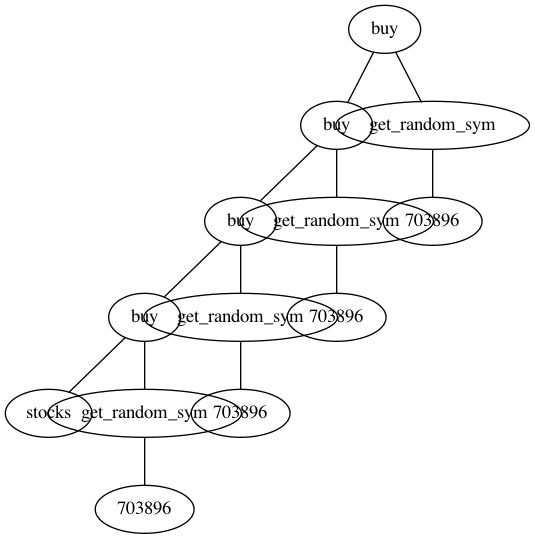

In [11]:
pop = toolbox.population(n=30)
hof = tools.HallOfFame(1)

mstats = stats()

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.1, ngen=50, halloffame=hof, stats=mstats, verbose=True)


plot(hof)

# Display the tree
from IPython.display import Image
Image(filename="tree0.png")